# 시작

In [1]:
import os
import json
from tqdm.notebook import tqdm
import sentencepiece as spm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 데이터 불러오기 & 전처리 & 저장

In [2]:
DATA_PATH = os.getenv('HOME') + '/aiffel/bert_qna/data'
MODEL_PATH = os.getenv('HOME') + '/aiffel/bert_qna/models'

def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

            
def load_raw_data(file):
    with open(os.path.join(DATA_PATH, file)) as f:
        json_data = json.load(f)
        print('{}를 불러왔습니다'.format(file))
        print_json_tree(json_data)
    return json_data

In [3]:
def _tokenize_whitespace(string):
    def _is_whitespace(c):
        return c == ' ' or c == '\t' or c == '\r' or c == '\n' or ord(c) == 0x202F
        
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word


def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token


def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)


def load_sentence_piece():
    path = os.getenv('HOME') + '/aiffel/bert_qna/models'
    vocab = spm.SentencePieceProcessor()
    vocab.load(os.path.join(path,'ko_32000.model'))
    return vocab


def dump_korquad(vocab, json_data, file):
    path = os.getenv('HOME') + '/aiffel/bert_qna/data'
    with open(os.path.join(path, file), "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [4]:
def load_data(max_seq_len, max_query_len, file):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(os.path.join(DATA_PATH, file), "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:max_query_len]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = max_seq_len - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= max_seq_len - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (max_seq_len - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (max_seq_len - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')
    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

# 모델 생성

In [5]:
def get_pad_mask(tokens):
    outputs = tf.cast(tf.math.equal(tokens, 0), tf.float32)
    outputs = tf.expand_dims(outputs, axis=1)
    return outputs


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    return 0.5 * x * (1 + tf.keras.backend.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer():
    return tf.keras.initializers.TruncatedNormal(stddev=0.02)

In [6]:
class SharedEmbedding(tf.keras.layers.Layer):
    '''
    BERT의 Token Embedding에 사용됨
    '''
    def __init__(self, config, name="weight_shared_embedding"):
        super().__init__(name=name)
        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight("weights", shape=[self.n_vocab, self.d_model], initializer=kernel_initializer())

    def call(self, inputs):
        return tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
    
    
class PositionalEmbedding(tf.keras.layers.Layer):
    '''
    BERT의 Position Embedding에 사용됨
    '''
    def __init__(self, config, name="position_embedding"):
        super().__init__(name=name)
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        outputs = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        return self.embedding(outputs)
        
    
class ScaleDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, name="scale_dot_product_attention"):
        super().__init__(name=name)

    def call(self, Q, K, V, mask):
        score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        scale = tf.math.divide(score, scale)
        scale -= 1.e9 * mask
        prob = tf.nn.softmax(scale, axis=-1)
        outputs = tf.matmul(prob, V)
        return outputs
    
    
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, config, name="multi_head_attention"):
        super().__init__(name=name)
        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer())

        self.attention = ScaleDotProductAttention(name="self_attention")
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer())

    def call(self, Q, K, V, mask):
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        mask_m = tf.expand_dims(mask, axis=1)
        attention = self.attention(Q_m, K_m, V_m, mask_m)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        attention = tf.reshape(attention, [batch_size, -1, config.n_head * config.d_head])
        outputs = self.W_O(attention)
        return outputs
    
    
class PositionWiseFeedForward(tf.keras.layers.Layer):
    def __init__(self, config, name="feed_forward"):
        super().__init__(name=name)
        self.dense1 = tf.keras.layers.Dense(config.d_model*4, activation=gelu, kernel_initializer=kernel_initializer())
        self.dense2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer())

    def call(self, inputs):
        outputs = self.dense1(inputs)
        return self.dense2(outputs)
    

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, config, name="encoder_layer"):
        super().__init__(name=name)
        self.attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, embedded, mask):
        attention = self.attention(embedded, embedded, embedded, mask)
        attention = self.dropout(attention)
        attention = self.norm1(embedded + attention)
        ffn = self.ffn(attention)
        ffn = self.dropout(ffn)
        return self.norm2(attention + ffn)

In [7]:
class BERT(tf.keras.layers.Layer):
    def __init__(self, config, name="bert"):
        super().__init__(name=name)
        self.token = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization()
        self.encoders = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]
        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, tokens, segments):
        mask = get_pad_mask(tokens)
        embed = self.token(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        outputs = self.dropout(embed)
        for encoder in self.encoders:
            outputs = encoder(outputs, mask)
        return outputs

In [8]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    
    
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, tokens, segments):
        logits = self.bert(tokens, segments)
        logits = self.dense(logits)
        start_logits, end_logits = tf.split(logits, 2, axis=-1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

# 모델 훈련

In [9]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()


def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [10]:
def train_model(mode, train_dataset, val_dataset, epochs):
    loss_fn = tf.keras.losses.sparse_categorical_crossentropy
    acc_fn = tf.keras.metrics.sparse_categorical_accuracy

    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

    best_acc = .0
    patience = 0
    history = {'loss':[], 'val_loss':[], 'start_accuracy':[], 'val_start_accuracy':[], 'end_accuracy':[], 'val_end_accuracy':[]}
    for epoch in range(epochs):
        train_start_loss, train_end_loss, train_start_acc, train_end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
        eval_start_loss, eval_end_loss, eval_start_acc, eval_end_acc = eval_epoch(model, val_dataset, loss_fn, acc_fn)
        print(f'eval {epoch} >> loss: {eval_start_loss:0.4f}, {eval_end_loss:0.4f}, acc: {eval_start_acc:0.4f}, {eval_end_acc:0.4f}')
        history['loss'].append(train_start_loss + train_end_loss)
        history['val_loss'].append(eval_start_loss + eval_end_loss)
        history['start_accuracy'].append(train_start_acc)
        history['val_start_accuracy'].append(eval_start_acc)
        history['end_accuracy'].append(train_end_acc)
        history['val_end_accuracy'].append(eval_end_acc)
        eval_acc = eval_start_acc + eval_end_acc
        if best_acc < eval_acc:
            patience = 0
            best_acc = eval_acc
            model.save_weights(os.path.join(MODEL_PATH, "korquad_bert_pretrain_with_train.hdf5"))
            print('save best model')
        else:
            patience += 1
        if 5 <= patience:
            print('early stopping')
            break
            
    return history

# 모델 시험 & 시각화

In [11]:
def do_predict(model, question, context):
    q_tokens = vocab.encode_as_pieces(question)[:MAX_QUE_LEN]
    c_tokens = vocab.encode_as_pieces(context)[:MAX_SEQ_LEN - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    y_start_idx = tf.keras.backend.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = tf.keras.backend.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)


def test_model(model):
    dev_json = os.path.join(DATA_PATH, "korquad_dev.json")
    total = 0
    right = 0
    with open(dev_json) as f:
        for i, line in enumerate(f):
            total += 1
            data = json.loads(line)
            question = vocab.decode_pieces(data['question'])
            context = vocab.decode_pieces(data['context'])
            answer = data['answer']
            answer_predict = do_predict(model, question, context)
            if answer in answer_predict:
                right += 1
                if i < 100:
                    print(i)
                    print("질문 : ", question)
                    print("지문 : ", context)
                    print("정답 : ", answer)
                    print("예측 : ", answer_predict, "\n")
    print('점수: {}/{}'.format(right, total))

In [12]:
def draw_history(history):
    epochs = len(history['loss'])
    x_range = range(1, epochs+1)
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    plt.plot(x_range, history['loss'], 'b-', label='loss')
    plt.plot(x_range, history['val_loss'], 'r--', label='val_loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(x_range, history['start_accuracy'], 'g-', label='start_accuracy')
    plt.plot(x_range, history['val_start_accuracy'], 'k--', label='val_start_accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(x_range, history['end_accuracy'], 'b-', label='end_accuracy')
    plt.plot(x_range, history['val_end_accuracy'], 'g--', label='val_end_accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

# 메인

### 데이터를 전처리하여 저장(1번만 수행)

In [13]:
# train_json_data = load_raw_data('KorQuAD_v1.0_train.json')

In [14]:
# dev_json_data = load_raw_data('KorQuAD_v1.0_dev.json')

In [15]:
# vocab = load_sentence_piece()
# dump_korquad(vocab, train_json_data, 'korquad_train_lms.json')
# dump_korquad(vocab, dev_json_data, 'korquad_dev_lms.json')

### 전처리된 데이터를 불러옴

In [16]:
MAX_SEQ_LEN = 384
MAX_QUE_LEN = 64
vocab = load_sentence_piece()
train_inputs, train_labels = load_data(MAX_SEQ_LEN, MAX_QUE_LEN, 'korquad_train_lms.json')
dev_inputs, dev_labels = load_data(MAX_SEQ_LEN, MAX_QUE_LEN, 'korquad_dev_lms.json')

Loading ...: |          | 0/? [00:00<?, ?it/s]

n_discard: 430


Loading ...: |          | 0/? [00:00<?, ?it/s]

n_discard: 78


In [17]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

## 전이학습 미적용

In [18]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "n_layer": 3, "n_seq": MAX_SEQ_LEN, "n_vocab": 0})
config.n_vocab = len(vocab)

model = BERT4KorQuAD(config)

In [19]:
history = train_model(model, train_dataset, dev_dataset, 10)

|          | 0/? [00:00<?, ?it/s]

eval 0 >> loss: 3.7081, 4.2661, acc: 0.1189, 0.1066
save best model


|          | 0/? [00:00<?, ?it/s]

eval 1 >> loss: 3.5645, 4.2257, acc: 0.1575, 0.1294
save best model


|          | 0/? [00:00<?, ?it/s]

eval 2 >> loss: 3.5555, 4.0404, acc: 0.1610, 0.1433
save best model


|          | 0/? [00:00<?, ?it/s]

eval 3 >> loss: 3.6935, 4.3829, acc: 0.1529, 0.1447


|          | 0/? [00:00<?, ?it/s]

eval 4 >> loss: 3.8610, 4.5375, acc: 0.1570, 0.1445


|          | 0/? [00:00<?, ?it/s]

eval 5 >> loss: 3.9012, 4.7129, acc: 0.1522, 0.1336


|          | 0/? [00:00<?, ?it/s]

eval 6 >> loss: 4.3928, 5.3240, acc: 0.1519, 0.1315


|          | 0/? [00:00<?, ?it/s]

eval 7 >> loss: 4.4543, 5.2874, acc: 0.1468, 0.1341
early stopping


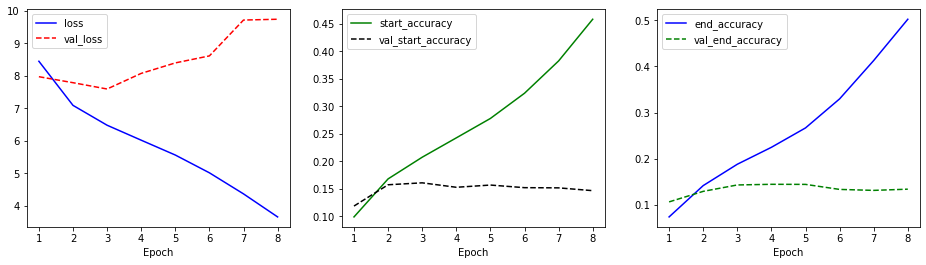

In [20]:
draw_history(history)

In [21]:
test_model(model)

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

71
질문 :  현재의 생물다양성은 대략 몇 종 인가?
지문 :  기독교 성경 내용에는 모든 종들을 방주에 태운다고 이야기하고 있으나, 어류나 수중 생물에 대해서는 언급하지 않았다. 이것을 신학적 의미로만 받아들이면 괜찮은 문제이나, 이 현상이 실제로 일어났다고 가정할 경우,이는 종 간 생존 환경의 차이에 대해서 간과하고 있다. 수중 생물이라 하더라도 종에 따라 생존할 수 있는 환경은 각각 다른 것이며, 40일 이내에 현존하는 가장 높은 산인 에베레스트 산도 잠기게 할 정도의 폭우로 인해 담수와 염수가 급작스럽게 섞일 경우, 급격한 삼투압 변화로 인해 대부분의 수생생물들이 폐사하게 되며, 결과적으로 육지 뿐 아니라 바다와 강의 모든 생태계가 파괴된다. 이후 5천년이라는 지극히 짧은 세월 동안 지구상의 동식물이 모두 페름기 대멸종 또는 K-T 대멸종에 준하는 대량절멸에 가까운 상태에서부터 시작하여 현재의 대략 870만(±120만)종에 달하는 생물다양성을 획득하려면 모든 생물들이 각 세대마다 종분화가 일어나야 할 만큼 엄청난 속도로 진화 및 번식이 (멸종 없이) 이루어져야만 가능한 일이다. (이와 관련하여 창조과학회 측에서는 북극곰의 예시를 통해 가지고 있던 특성이 없어지는 것이 진화가 아니라고 주장하지만, 통상적으로 알려진 바와 같이 생물학에서는 이미 존재하는 특성이 없어지는 현상, 즉 퇴화 역시 진화의 정의에 포함된다.) 즉, 노아의 홍수가 실재하는 사건이었다면 진화적 종분화가 현재까지 알려진 것과 비교할 수 없이 엄청난 속도로 이루어져야만 현재 지구의 생물다양성을 설명할 수 있다. 게다가 이것은 현재의 생물종 멸종 속도를 전혀 고려하지 않았다. 다시 말해, 노아의 홍수가 실재하는 전지구적인 사건이기 위해서는 최소 캄브리아기 대폭발 수준의 폭발적인 진화적 종분화가 1-2억년이 아니라 최대 3-4천년 이내에 이루어졌어야만 현생 지구의 생물다양성에 대한 설명이 가능해진다. 그보다 더 중요한 것은, 각 동물들이 차지하는 영역과 먹이사슬에서의 위치, 375일 동안 먹

## 전이학습 적용

In [22]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "n_layer": 3, "n_seq": MAX_SEQ_LEN, "n_vocab": 0})
config.n_vocab = len(vocab)

model = BERT4KorQuAD(config)

#  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
enc_tokens = np.random.randint(0, len(vocab), (4, 10))
segments = np.random.randint(0, 2, (4, 10))
model(enc_tokens, segments)

# checkpoint 파일로부터 필요한 layer를 불러온다. 
model.load_weights(os.path.join(MODEL_PATH, "bert_pretrain_32000.hdf5"), by_name=True)

model.summary()

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  10662400  
_________________________________________________________________
dense_37 (Dense)             multiple                  514       
Total params: 10,662,914
Trainable params: 10,662,914
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = train_model(model, train_dataset, dev_dataset, 10)

|          | 0/? [00:00<?, ?it/s]

eval 0 >> loss: 3.8049, 4.3861, acc: 0.1053, 0.0871
save best model


|          | 0/? [00:00<?, ?it/s]

eval 1 >> loss: 3.6908, 4.2989, acc: 0.1250, 0.0992
save best model


|          | 0/? [00:00<?, ?it/s]

eval 2 >> loss: 3.6686, 4.2164, acc: 0.1599, 0.1343
save best model


|          | 0/? [00:00<?, ?it/s]

eval 3 >> loss: 3.7195, 4.2479, acc: 0.1482, 0.1348


|          | 0/? [00:00<?, ?it/s]

eval 4 >> loss: 3.7655, 4.4741, acc: 0.1536, 0.1483
save best model


|          | 0/? [00:00<?, ?it/s]

eval 5 >> loss: 3.7282, 4.1609, acc: 0.1555, 0.1334


|          | 0/? [00:00<?, ?it/s]

eval 6 >> loss: 3.8248, 4.4420, acc: 0.1657, 0.1491
save best model


|          | 0/? [00:00<?, ?it/s]

eval 7 >> loss: 3.9627, 4.5540, acc: 0.1605, 0.1489


|          | 0/? [00:00<?, ?it/s]

eval 8 >> loss: 4.0780, 4.7165, acc: 0.1531, 0.1522


|          | 0/? [00:00<?, ?it/s]

eval 9 >> loss: 4.2415, 4.9576, acc: 0.1494, 0.1471


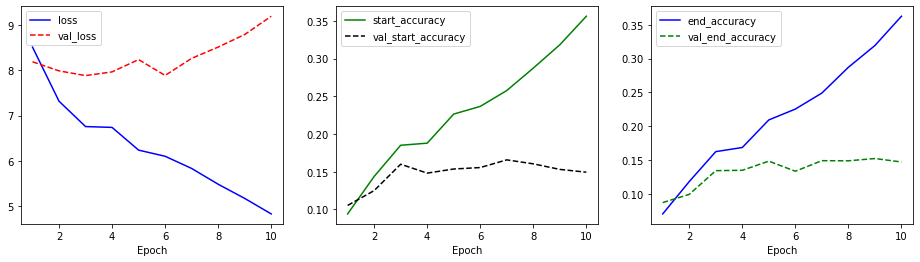

In [24]:
draw_history(history)

In [25]:
test_model(model)

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

2
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내

56
질문 :  제칠일안식교에서 비롯된 의사과학의 한 종류인 유사지질학의 이름은 무엇인가?
지문 :  역사학과 과학의 발달이 더뎠던 고대사회에서는, 성경이 단순한 교리적인 부분 뿐 아니라 역사책으로서의 권위도 높았기에 노아의 방주를 역사적인 존재로서 다루고 있었다. 이는 제칠일안식교에서 비롯된 의사과학의 한 종류인 유사지질학인 홍수지질학과 같은 것에 영향을 주었으며, 과거 신학에서는 이러한 근본주의적 해석을 받아들여 역사와 사회적인 모든 부분에 있어 성경을 교과서로 채택할 것을 촉구했다. 이러한 홍수지질학을 주장했던 유사지질학자들은 성경에 나오는 노아의 홍수가 어딘가에 그 흔적이 남아 있을것이라고 주장하며 노아의 방주를 찾기 위한 노력을 했다고 주장한다. 이들은 같은 메소포타미아 지방의 신화인 이슬람교 경전이나 길가메쉬 서사시등의 신화를 들어서 이를 근거라고 주장하기도 했다. 그러나 이러한 전통적 근본주의적 시각은 과거에는 상당히 힘을 얻었으나, 역사학과 과학의 발달에 따라 힘을 잃게 되었고, 홍수지질학은 유사과학으로서 남게 되었다. 현대에는 뒤의 실존논란에서 다루는 것처럼 이러한 근본주의적 해석은 비과학적인 해석으로 여기는 것이 일반적이지만, 남침례교로 대표되는 극보수주의계열 기독교에서는 아직도 이것이 받아들여지고 있다.
정답 :  홍수지질학
예측 :  노아의 방주를 역사적인 존재로서 다루고 있었다. 이는 제칠일안식교에서 비롯된 의사과학의 한 종류인 유사지질학인 홍수지질학과 같은 것에 영향을 주었으며, 과거 신학에서는 이러한 근본주의적 해석을 받아들여 역사와 사회적인 모든 부분에 있어 성경을 교과서로 채택할 것을 촉구했다. 이러한 홍수지질학을 주장했던 유사지질학자들은 성경에 나오는 노아의 홍수가 어딘가에 그 흔적이 남아 있을것이라고 주장하며 노아의 방주를 찾기 위한 노력을 했다고 주장한다. 이들은 같은 메소포타미아 지방의 신화인 이슬람교 경전이나 길가메쉬 서사시등의 신화를 들어서 이를 근거라고 주장하기도 했다. 그러나 이러한 전통적 근본주의적 시각은 과거에는

99
질문 :  미야코 만 해전에서 아쓰오카 바키치 함장이 폭풍우를 만난 년도는?
지문 :  일련의 하코다테 전쟁은 적아 쌍방의 문서에 마쓰오카 바키치 함장의 능란한 조함 능력과 냉정한 지휘만이 기록되어 있다. 함포 사격으로 마쓰마에 성을 공격하여 엄호한 이후, 1869년 메이지 2년 3월 25일 미야코 만 해전에서는 폭풍우를 만나 요함과 헤어졌을 때에 만날 약속했던 하치노헤 항에서 대기하고 있었기 때문에 참전에는 이르지 못했다. 이 폭풍우 때도 “함장 마쓰오카 바키치는 배를 조정하는 명수로 로프 하나 손상되지 않았다”고 타고 있던 하야시 다다스가 남긴 바 있다. 이 귀로에서 신정부 군의 철갑함의 추격을 받았다. 기관 능력의 차이로 인한 속도차 때문에 도주가 불가능하다고 판단하고 맞장 공격을 하겠다고 전투 준비를 했지만, 철갑선의 사정거리에 들어간 순간에 순풍이 불기 시작하여 추격을 뿌리치고 하코다테로 돌아올 수 있었다.
정답 :  1869년
예측 :  1869년 메이지 2년 

점수: 1513/5774


## LMS의 BERT 모델 & 전이학습 적용

In [26]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + tf.keras.backend.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [27]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [28]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [29]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [30]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [31]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [32]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [33]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [34]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [35]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

In [36]:
model = BERT4KorQuAD(config)

enc_tokens = np.random.randint(0, len(vocab), (4, 10))
segments = np.random.randint(0, 2, (4, 10))
model(enc_tokens, segments)

# checkpoint 파일로부터 필요한 layer를 불러온다. 
model.load_weights(os.path.join(MODEL_PATH, "bert_pretrain_32000.hdf5"), by_name=True)

model.summary()

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  10662400  
_________________________________________________________________
dense_56 (Dense)             multiple                  514       
Total params: 10,662,914
Trainable params: 10,662,914
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = train_model(model, train_dataset, dev_dataset, 10)

|          | 0/? [00:00<?, ?it/s]

eval 0 >> loss: 3.7559, 4.3319, acc: 0.1218, 0.1031
save best model


|          | 0/? [00:00<?, ?it/s]

eval 1 >> loss: 3.6686, 4.1998, acc: 0.1466, 0.1268
save best model


|          | 0/? [00:00<?, ?it/s]

eval 2 >> loss: 3.6900, 4.3697, acc: 0.1570, 0.1383
save best model


|          | 0/? [00:00<?, ?it/s]

eval 3 >> loss: 3.7745, 4.2224, acc: 0.1610, 0.1527
save best model


|          | 0/? [00:00<?, ?it/s]

eval 4 >> loss: 3.7024, 4.2825, acc: 0.1582, 0.1555


|          | 0/? [00:00<?, ?it/s]

eval 5 >> loss: 3.9298, 4.5554, acc: 0.1552, 0.1499


|          | 0/? [00:00<?, ?it/s]

eval 6 >> loss: 4.2423, 4.9311, acc: 0.1466, 0.1434


|          | 0/? [00:00<?, ?it/s]

eval 7 >> loss: 4.2167, 5.1085, acc: 0.1498, 0.1394


|          | 0/? [00:00<?, ?it/s]

eval 8 >> loss: 4.5998, 5.3173, acc: 0.1422, 0.1338
early stopping


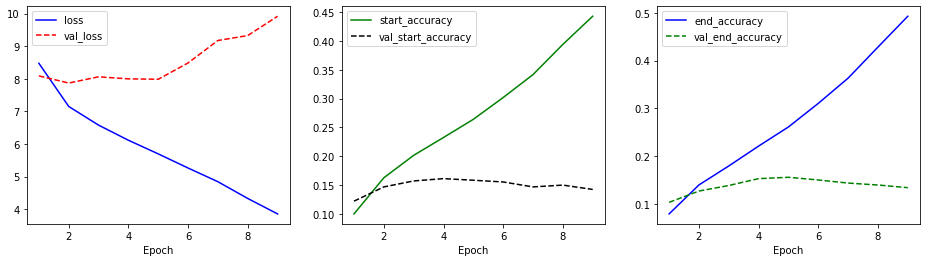

In [38]:
draw_history(history)

In [39]:
test_model(model)

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 

2
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12

35
질문 :  헤이그가 사적생활을 하다가 정계로 돌아갔던 해는 언제인가?
지문 :  그의 편에 헤이그는 지구촌의 논점들의 국내적 정치 노력들에 관해서만 근심한 레이건의 가까운 조언자들을 "외교 정책의 아마추어"로 묘사하였다. 1982년 6월 25일 결국적으로 온 그의 국무장관으로서 사임은 불가능한 상황이 된 것을 끝냈다. 헤이그는 개인적 생활로 돌아갔다가 1988년 대통령 선거를 위한 공화당 후보직을 안정시키는 시도를 하는 데 충분하게 정계로 돌아갔으나 후보직을 이기는 데 성원을 가지지 않았다. 그는 외교 정책 논쟁들에 연설자로서 활동적으로 남아있었으나 그의 전념은 정치에서 개인적 생활로 옮겨졌다. 그는 Worldwide Associates Inc.의 국제적 상담 회사에 의하여 기용되었고, 그 기구의 의장과 회장이 되었다.
정답 :  1988년
예측 :  1988년 

43
질문 :  노아는 누구의 명령에 따라 배를 만들고 가족과 동물들을 태웠는가?
지문 :  노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가 올 것을 미리 알게 된다. 그는 길이 300 규빗, 너비 50 규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에 탄다. 대홍수를 만나 모든 생물(물고기 제외)이 전멸하고 말았지만, 이 방주에 탔던 노아의 가족과 동물들은 살아 남았다고 한다.〈창세기〉 6장 14~16절에 보면 길이 300규빗 (약 135m), 폭 50 규빗 (약 22.5m), 높이 30 규빗 (약 13.5m)인 이 배는 지붕과 문을 달고 배 안은 3층

88
질문 :  막부 해군이 정박하고 있던 시나가와 해역을 탈출한 시간은?
지문 :  1868년 게이오 4년 4월 11일 에도 성 무혈 개성을 한 이후 신정부 군에게 양도가 약속되어 있었다. 그러나 해군 부총재, 에노모토 다케아키가 기상 불량 등을 이유로 이를 연기한 후에 결국 인도를 거부했다. 도쿠가와 요시노부를 슨푸 번에 이송할 때의 태운 함선으로 사용한 후, 8월 19일 자정 (20일)에는 마쓰오카 바키치를 함장으로 카이요마루, 가이텐마루, 신소쿠마루, 간린마루 등과 함께 막부 해군이 정박하고 있던 시나가와 해역을 탈출했다. 그 때 태풍에 휘말려 침몰직전이 되었지만, 1개월만에 에노모토 해군과 합류하였다. 에조치에 건너가 하코다테 전쟁에서는 에노모토(하코다테 정부) 해군의 주력함이 되었다. 영국이 기증했을 때 엠퍼러(Emperor, 기증 당시 일본의 수장은 황제가 아니라 쇼군으로 인식되고 있었기 때문에 장군을 지칭)로 명명하고 있음에서 알 수 있듯이, 쇼군용 유람 요트로 기증되었다고 생각되지만, 세상이 그것을 허락하지 않았다. 아이러니하게도, 군함에 통합되어 실제로 쇼군이 첫 좌승한 것이 대정봉환 이후 슨푸 번에 이송되었을 때였다.
정답 :  자정
예측 :  19일 자정 (20일)에는 마쓰오카 바키치를 함장으로 카이요마루, 가이텐마루, 신소쿠마루, 간린마루 등과 함께 막부 해군이 정박하고 있던 시나가와 해역을 탈출했다. 그 때 태풍에 휘말려 침몰직전이 되었지만, 1개월만에 에노모토 해군과 합류하였다. 에조치에 건너가 하코다테 전쟁에서 

90
질문 :  1868년 당시 일본의 해군 부총재는?
지문 :  1868년 게이오 4년 4월 11일 에도 성 무혈 개성을 한 이후 신정부 군에게 양도가 약속되어 있었다. 그러나 해군 부총재, 에노모토 다케아키가 기상 불량 등을 이유로 이를 연기한 후에 결국 인도를 거부했다. 도쿠가와 요시노부를 슨푸 번에 이송할 때의 태운 함선으로 사용한 후, 8월 19일 자정 (20일)에는 마쓰오카 바키치를 함장으로 카이요마루, 가이텐

#  결론

BERT 모델을 이해하기 위해 LMS의 모델을 일부 수정하여 사용하였다.   
그 과정에서 문제가 있었는지 미리 학습된 모델의 가중치를 불러왔을때 변화가 없었다.   
다시 LMS모델을 그대로 사용하여 미리 학습된 모델의 가중치를 불러와 보았으나 역시 변화가 없었다.
학습 노드의 노트북 상에서 학습을 진행해도 변화가 없었던 것으로 미루어 미리 학습된 모델이 충분히 학습되지 않았을 것으로 추정된다.
그래서 본 노드에서 목적하는 바는 달성할 수 없었다.

예측된 부분에 정답이 있는 경우를 맞는 것으로 본다고 하여도 전반적으로 25% 정도의 정답률을 보였고, 문장길이 등을 고려해보면 잘 맞추지 못했다고 볼 수 있다.   
LOSS 그래프로 추정할 때 더 나은 결과를 얻기 위해서는 더 낮은 학습률로 더 큰 모델을 사용하여야 할 것으로 보인다.   